In [1]:
using Plots, Statistics, NaNStatistics, LinearAlgebra, Serialization, ParticleFilters, StatsBase, Distributions

include("../utils/import.jl")
using .Import

include("../utils/figs.jl")
using .Figs

fig_directory = "../fig/"
filetype = ".png"
function save(name::String)
    savefig(fig_directory*name*filetype)
end

save (generic function with 1 method)

# SHORT runs

**Parameters:**\
steps: 100\
lookahead: 100\
runs: 25

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
active infinite: 45min\
passive infinite: 1h\
active finite: 2h\
passive finite: 3h

In [5]:
# Experiment parameters
runs = 25
actions = ["C1", "C2", "C3", "B1", "B2", "B3", "B"]
afc, aic, pfc, pic = "active finite", "active infinite", "passive finite", "passive infinite"

# Plotting Parameters
labels = [afc aic pfc pic]
discount = 0.99
window = 10
;

In [3]:
# Import experiments

# afc: active, finite, constrained
ids_afc = ["active_finite_2341_111423", "active_finite_2341_112136", "active_finite_2341_112818", "active_finite_2341_11353", "active_finite_2341_11421", "active_finite_2341_114924", "active_finite_2341_115420", "active_finite_2341_120135", "active_finite_2341_120830", "active_finite_2341_121329", "active_finite_2341_121822", "active_finite_2341_122520", "active_finite_2341_123155", "active_finite_2341_123657", "active_finite_2341_12420", "active_finite_2341_124914", "active_finite_2341_125547", "active_finite_2341_13031", "active_finite_2341_130942", "active_finite_2341_131639"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_2341_081552", "active_infinite_2341_08192", "active_infinite_2341_082154", "active_infinite_2341_082450", "active_infinite_2341_082741", "active_infinite_2341_083037", "active_infinite_2341_083323", "active_infinite_2341_083620", "active_infinite_2341_08397", "active_infinite_2341_084152", "active_infinite_2341_084432", "active_infinite_2341_084636", "active_infinite_2341_084937", "active_infinite_2341_085144", "active_infinite_2341_085434", "active_infinite_2341_085641", "active_infinite_2341_085849", "active_infinite_2341_090143", "active_infinite_2341_090348", "active_infinite_2341_090555"]

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_133734", "passive_finite_2341_134420", "passive_finite_2341_135419", "passive_finite_2341_140418", "passive_finite_2341_141340", "passive_finite_2341_142112", "passive_finite_2341_143054", "passive_finite_2341_143723", "passive_finite_2341_14478", "passive_finite_2341_145331", "passive_finite_2341_15005", "passive_finite_2341_150918", "passive_finite_2341_151816", "passive_finite_2341_152817", "passive_finite_2341_153447", "passive_finite_2341_15442", "passive_finite_2341_155022", "passive_finite_2341_15590", "passive_finite_2341_16083", "passive_finite_2341_161435"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_2341_09546", "passive_infinite_2341_095718", "passive_infinite_2341_100046", "passive_infinite_2341_100348", "passive_infinite_2341_100725", "passive_infinite_2341_101050", "passive_infinite_2341_101342", "passive_infinite_2341_101638", "passive_infinite_2341_101858", "passive_infinite_2341_102143", "passive_infinite_2341_102442", "passive_infinite_2341_102740", "passive_infinite_2341_103059", "passive_infinite_2341_103410", "passive_infinite_2341_10377", "passive_infinite_2341_103953", "passive_infinite_2341_104218", "passive_infinite_2341_104429", "passive_infinite_2341_104659", "passive_infinite_2341_104957"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
;

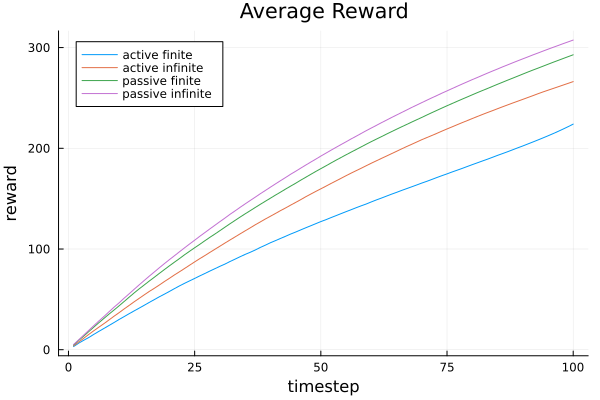

In [6]:
Figs.plot_cumulative_avg_r_multiple_experiments([r_afc, r_aic, r_pfc, r_pic], discount, labels, "Average Reward")

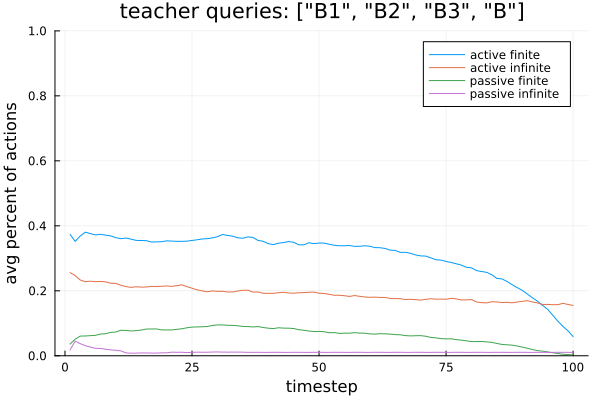

In [8]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic], ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

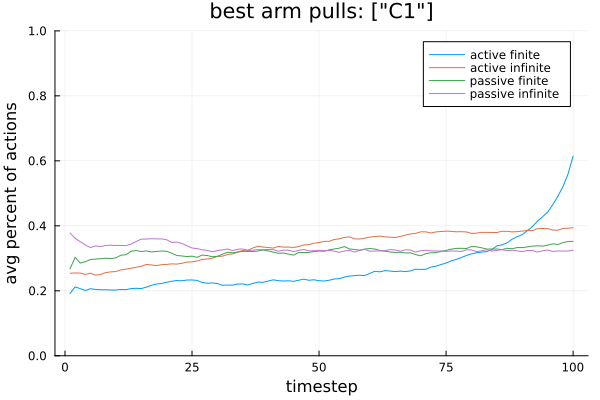

In [9]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic], ["C1"], window, labels, "best arm pulls: ")

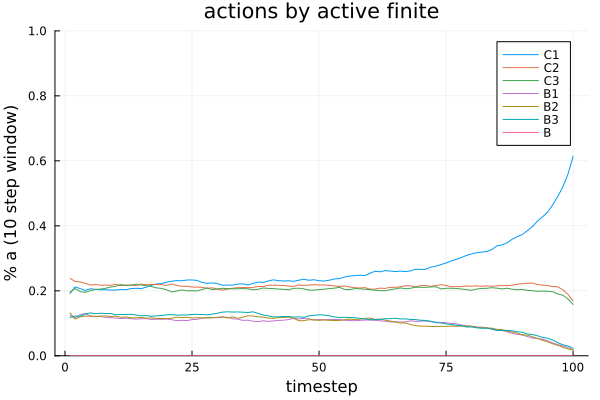

In [10]:
alg = afc
act = a_afc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

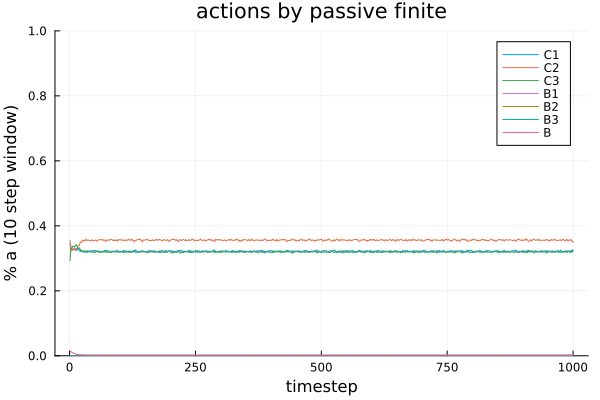

In [22]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

# LONG runs

**Parameters:**\
steps: 1000\
lookahead: 5\
runs: 20

_num items, arms, teachers: 3\
granularity of U and D: 3\
teacher betas: \[0.0, 0.01, 50.0\]\
state IDs: 1217, 1226, 1235, 1245, 4586, 4589, 4629, 4638, 4641, 1572, 1712, 3191, 3204, 3437, 3446, 3514, 3526, 3616, 4151, 4426_

**Algorithms:**\
ATS/active: select teachers and arms by solving POMDP\
passive: solve POMDP, but can't pick which teacher gets queried\
naive-X: act randomly for X steps, then always pull expected-best arm\
random: select teachers and arms randomly\
arms: pull arms randomly

**Variables:**\
discount: 0.9 (discounted) or 1.0 (undiscounted)\
horizon: finite or infinite\
rollout: random (all actions) or constrained (arm-only)

**Time:**\
*active infinite: 2.5h\
passive infinite: 2.5h\
*active finite: 3.5h\
*passive finite: 3.5h

In [15]:
# Experiment parameters
runs = 20
actions = ["C1", "C2", "C3", "B1", "B2", "B3", "B"]
afc, aic, pfc, pic = "active finite", "active infinite", "passive finite", "passive infinite"

# Plotting Parameters
labels = [afc aic pfc pic]
discount = 0.999
window = 10
;

In [16]:
# Import experiments

# afc: active, finite, constrained
ids_afc = ["active_finite_23331_22581", "active_finite_23331_230912", "active_finite_23331_23194", "active_finite_23331_232832", "active_finite_23331_233745", "active_finite_23331_234620", "active_finite_23331_235559", "active_finite_2341_00042", "active_finite_2341_001352", "active_finite_2341_002354", "active_finite_2341_003143", "active_finite_2341_003937", "active_finite_2341_004937", "active_finite_2341_005730", "active_finite_2341_010754", "active_finite_2341_011826", "active_finite_2341_012934", "active_finite_2341_013739", "active_finite_2341_014528", "active_finite_2341_015325"]

# aic: active, infinite, constrained
ids_aic = ["active_infinite_23331_173929", "active_infinite_23331_174758", "active_infinite_23331_175550", "active_infinite_23331_180158", "active_infinite_23331_180838", "active_infinite_23331_18164", "active_infinite_23331_182331", "active_infinite_23331_183051", "active_infinite_23331_183832", "active_infinite_23331_18475", "active_infinite_23331_185539", "active_infinite_23331_190344", "active_infinite_23331_191151", "active_infinite_23331_19184", "active_infinite_23331_192554", "active_infinite_23331_194737", "active_infinite_23331_195422", "active_infinite_23331_200216", "active_infinite_23331_200820", "active_infinite_23331_201429"] 

# pfc: passive, finite, constrained
ids_pfc = ["passive_finite_2341_020331", "passive_finite_2341_021258", "passive_finite_2341_022038", "passive_finite_2341_022957", "passive_finite_2341_023919", "passive_finite_2341_024851", "passive_finite_2341_02583", "passive_finite_2341_030527", "passive_finite_2341_031352", "passive_finite_2341_032256", "passive_finite_2341_033150", "passive_finite_2341_034040", "passive_finite_2341_034844", "passive_finite_2341_03568", "passive_finite_2341_040431", "passive_finite_2341_041158", "passive_finite_2341_041938", "passive_finite_2341_042739", "passive_finite_2341_04373", "passive_finite_2341_044432"]

# pic: passive, infinite, constrained
ids_pic = ["passive_infinite_23331_202225", "passive_infinite_23331_202939", "passive_infinite_23331_203640", "passive_infinite_23331_204346", "passive_infinite_23331_20514", "passive_infinite_23331_205811", "passive_infinite_23331_21041", "passive_infinite_23331_211040", "passive_infinite_23331_211639", "passive_infinite_23331_21247", "passive_infinite_23331_212956", "passive_infinite_23331_213613", "passive_infinite_23331_214235", "passive_infinite_23331_215023", "passive_infinite_23331_215646", "passive_infinite_23331_220450", "passive_infinite_23331_221250", "passive_infinite_23331_222018", "passive_infinite_23331_222659", "passive_infinite_23331_223256"]

s_afc, t_afc, a_afc, r_afc = Import.import_IDs(ids_afc, runs, directory="..")
s_aic, t_aic, a_aic, r_aic = Import.import_IDs(ids_aic, runs, directory="..")
s_pfc, t_pfc, a_pfc, r_pfc = Import.import_IDs(ids_pfc, runs, directory="..")
s_pic, t_pic, a_pic, r_pic = Import.import_IDs(ids_pic, runs, directory="..")
;

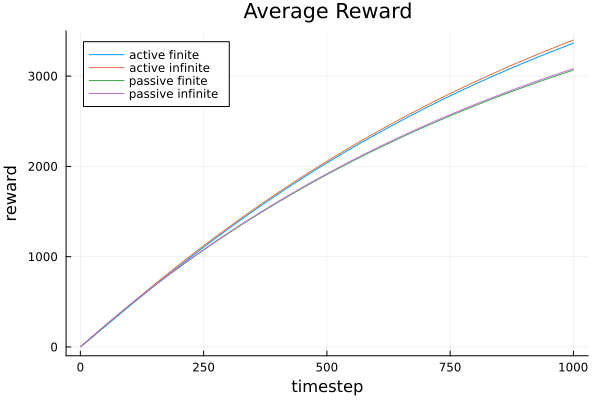

In [17]:
Figs.plot_cumulative_avg_r_multiple_experiments([r_afc, r_aic, r_pfc, r_pic], discount, labels, "Average Reward")

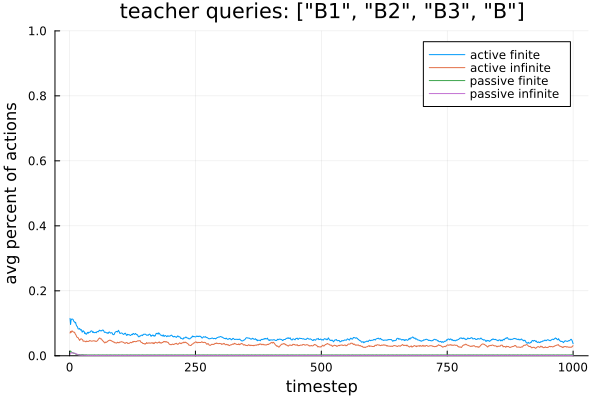

In [18]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic], ["B1", "B2", "B3", "B"], window, labels, "teacher queries: ")

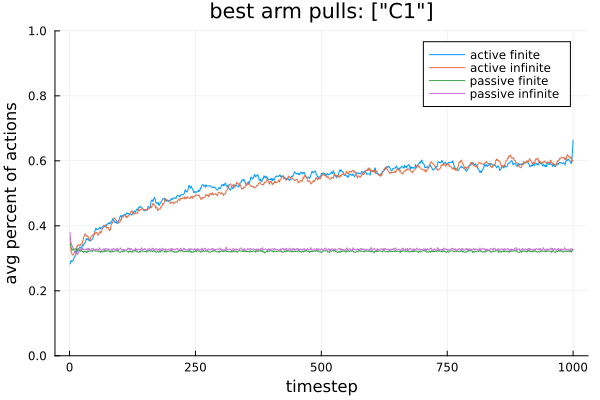

In [19]:
Figs.plot_actions_in_list_rolling_multiple_experiments([a_afc, a_aic, a_pfc, a_pic], ["C1"], window, labels, "best arm pulls: ")

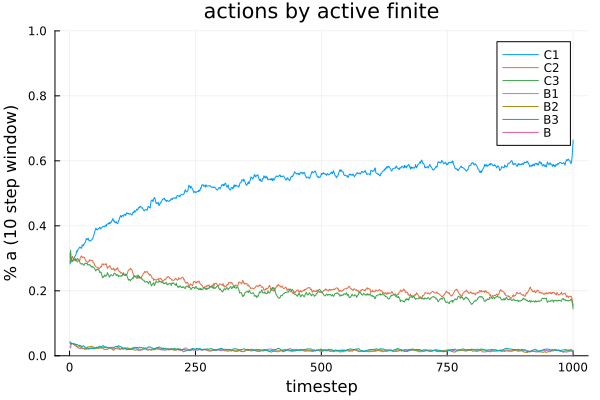

In [20]:
alg = afc
act = a_afc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)

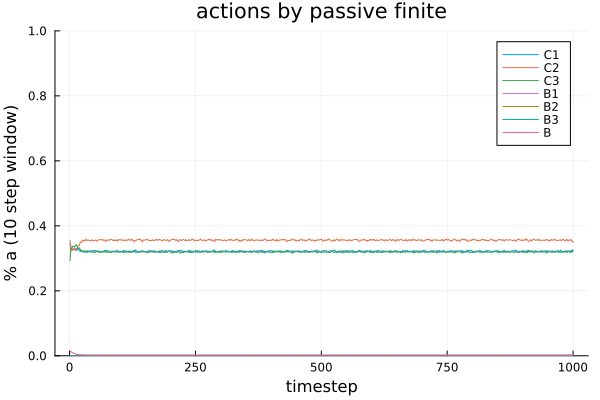

In [21]:
alg = pfc
act = a_pfc
Figs.plot_proportion_actions_all(act, actions, window, "actions by "*alg)